
 # Group 97 - Machine Learning (Long Notebook)
 Ilaria Crivellari, Kirill Menke, Moritz -surname-

## Search Domain Knowledge

We made some initial research about the russian house market to explore which features have the most impact on the house prices in Moscow. Thereby, we found the following papers on Google Scholar that helped us to get a better understanding of the situation:
- https://www.researchgate.net/publication/227488895_The_price_of_Moscow_apartments
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3374436


Moreover we found an old kaggle competition related to house price predictions in Moscow which provided some geographic-related data:
- https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/35585 


As a result of studying these papers and the old kaggle competition we decided to include some additional features which will be described below.

## Loading data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.neighbors import BallTree, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import RidgeCV, BayesianRidge
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.metrics.pairwise import haversine_distances
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Reading train/test data
apartments_train = pd.read_csv("data/apartments_train.csv")
buildings_train = pd.read_csv("data/buildings_train.csv")
apartments_test = pd.read_csv("data/apartments_test.csv")
buildings_test = pd.read_csv("data/buildings_test.csv")
metro_stations = pd.read_csv("data/metro_stations.csv")

# External datasources
sub_area_centers = pd.read_csv("data/sberbank_sub_areas.csv")
# sub_areas = gp.read_file('data/mo_kag_SRHM.shp')
sberbank_data = pd.read_csv("data/sberbank.csv")

# Merge Tables: Apartments and Buildings
train_df = apartments_train.merge(buildings_train, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
test_df = apartments_test.merge(buildings_test, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
print("Amount of training samples: ", len(train_df))
print("Amount of test samples: ", len(test_df))

# Merge train and test data
all_data = pd.concat([train_df, test_df])
all_data.describe()

Amount of training samples:  23285
Amount of test samples:  9937


,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,20450.000000,2.328500e+04,33222.000000,26268.000000,27321.000000,33222.000000,33222.000000,8212.000000,17111.000000,27633.000000,...,33067.000000,32054.000000,27579.000000,33222.000000,32685.000000,32685.000000,32685.000000,23567.000000,20985.000000,21831.000000
mean,1.855208,2.355617e+07,74.658347,12.646894,38.961378,9.033773,2.193396,1.038602,3.399897,0.749177,...,4.655276,2002.583391,2.213750,17.758082,0.403335,0.928285,0.744103,0.567785,0.793424,0.164995
std,1.089435,5.264393e+07,57.989504,6.660294,31.915799,8.216781,1.085552,0.346312,12.489861,0.790536,...,3.155880,23.156363,1.034136,11.074147,0.490574,0.258019,0.436371,0.558527,0.404858,0.551502
min,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,...,2.000000,1989.000000,2.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,1.064500e+07,59.700000,10.700000,31.000000,7.000000,2.000000,1.000000,2.800000,1.000000,...,5.000000,2013.000000,2.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,2.050000e+07,85.000000,15.600000,45.400000,12.000000,3.000000,1.000000,3.000000,1.000000,...,7.000000,2019.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,350.000000,4.000000,...,11.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


## Exploratory Data Analysis (EDA)
We extensively explorated the data, both single features and relation between them. We derived hypotheses from our findings and decided whether to keep data that seemed unintuitive at first, or whether there is predictive power in it.



### Analyze Target Distribution
To aviod predicting negative values, the target variable was log-transformed before before fitting our models and computing the prediction error. This happens through using the TransformedTargetRegressor when building the model.

Thr results are the following price ranges:

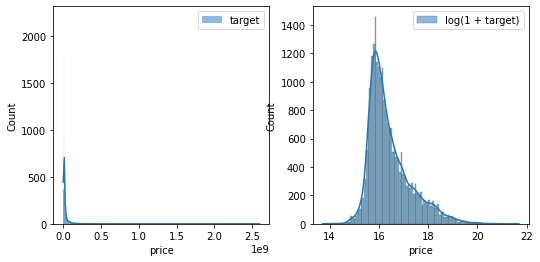

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=-0.2)

trans_data = pd.DataFrame(np.log1p(train_df["price"]), columns=["price"])

sns.histplot(train_df, x="price", label="target", kde=True, ax=ax1)
sns.histplot(trans_data, x="price", label="log(1 + target)", kde=True, ax=ax2)

ax1.legend()
ax2.legend();

### Analyzing Missing Data

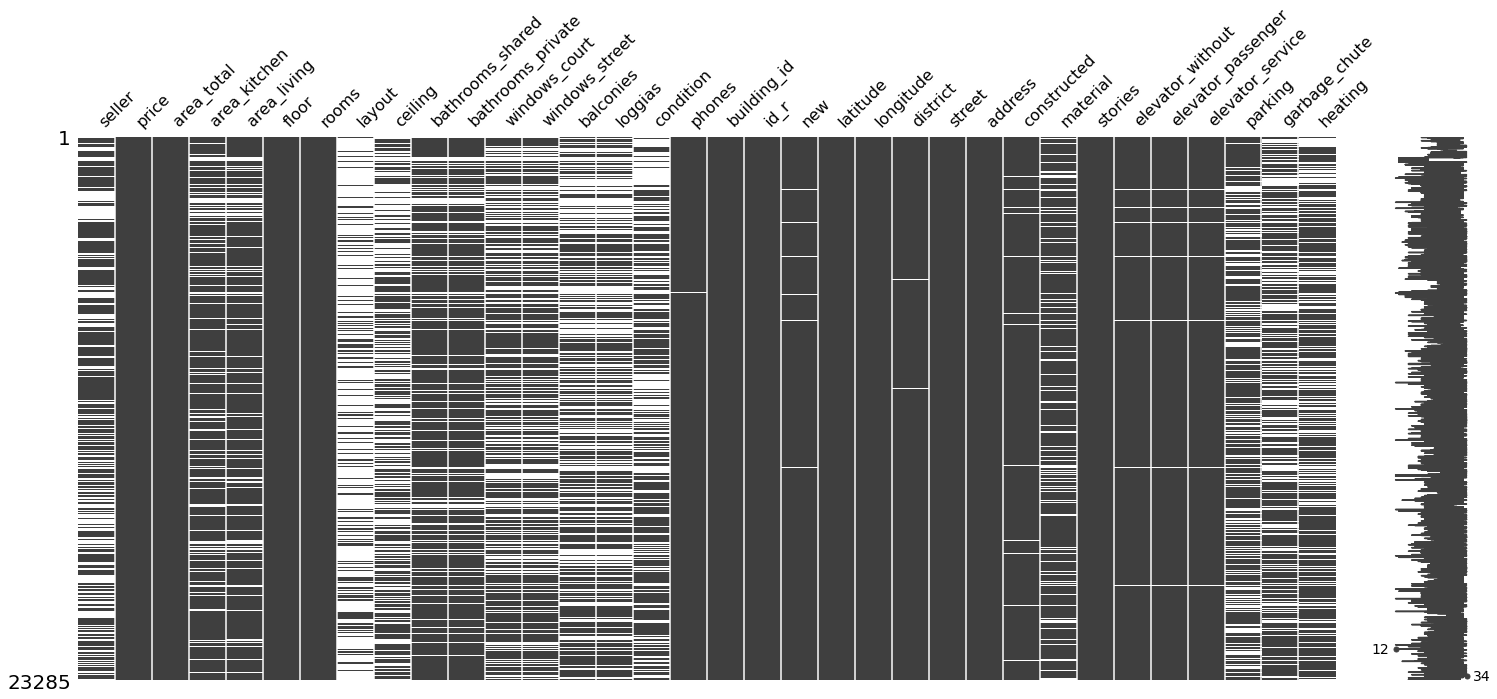

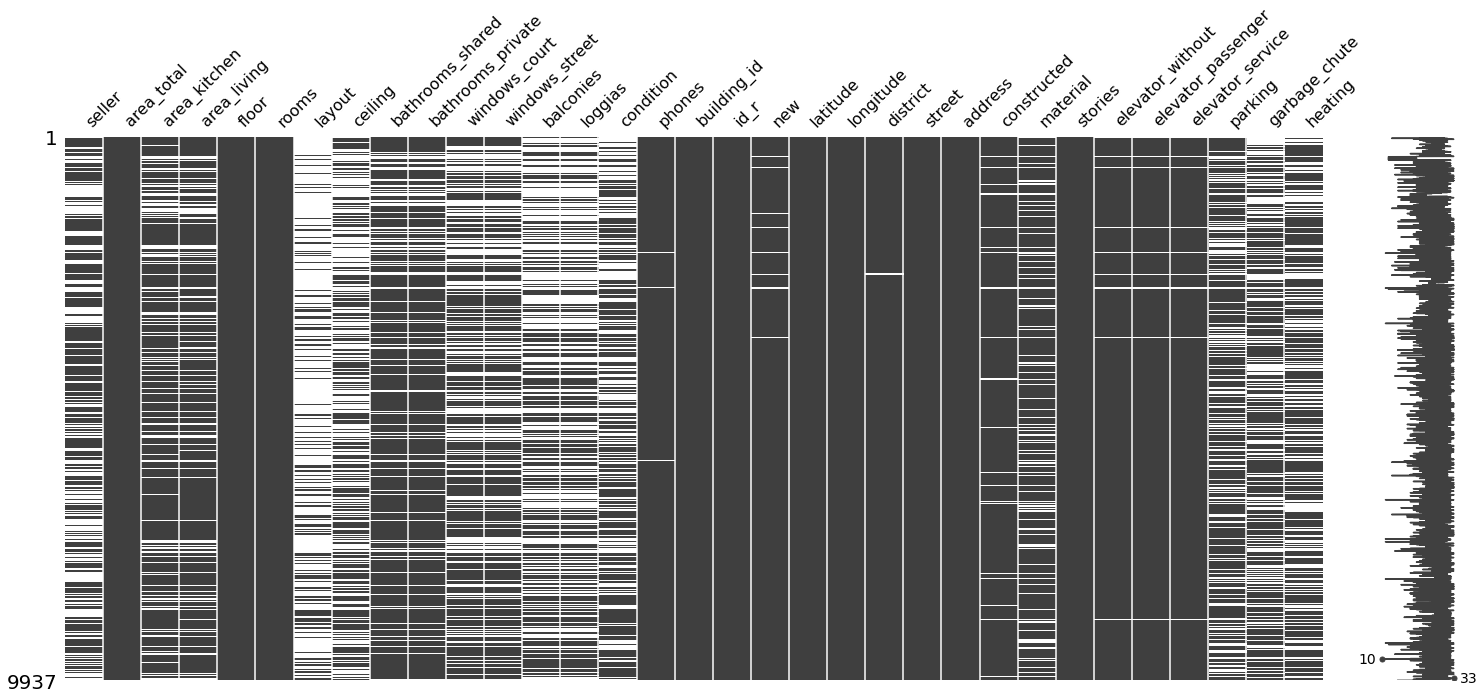

In [46]:
msno.matrix(train_df)
msno.matrix(test_df);

Analyzing the missing values, one can see that some features have more than 70% of missing values. We tried out different imputation strategies on the whole feature set to deal with that: 
- Imputing numerical features with mean/ median and catagorical features with most_frequent
- KNN imputation: Choosing the most frequent value of the nearest k neighbors in the hyperspace for imputation
- Iterative imputation: Estimates the missing values of each feature from all the other features
- Constant imputation: Imputing missing values with -999. This was chosen since the value does not appear in the value set of any feature.


Surprisingly, the best performing imputation which was also used in the final submission was the constant imputation. As we impute all the missing value with -999 – a value which is not contained in the value set of any respective feature – our tree boosting model is able to deduce information from missing values. Apparently missing values itself give a better indication for the real price.

In [5]:
train_df['address'] = LabelEncoder().fit_transform(train_df['address'])
train_df['street'] = LabelEncoder().fit_transform(train_df['street'])

y = train_df.price
X = train_df.drop("price", axis=1)

In [6]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [6]:
np.random.seed(42)

model_lgbm = LGBMRegressor(max_depth=6, n_estimators=1200, learning_rate=0.1)
trans_lgbm = TransformedTargetRegressor(regressor=model_lgbm, func=np.log1p, inverse_func=np.expm1)


# Constant Imputer
pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value=-999), trans_lgbm)
print("Running ConstantImputer")
ci_scores = pd.DataFrame(cross_val_score(pipe, X, y, scoring=make_scorer(rmsle)))


# Simple Imputer
categorical_columns = ["seller", "layout", "condition", "district", "material", "parking", "heating", "street", "address"]
numerical_columns = train_df.drop(categorical_columns + ["price"], axis=1).columns

imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="mean"), numerical_columns),
        ('cat', SimpleImputer(strategy="most_frequent"), categorical_columns)
])

pipe = make_pipeline(imputer, trans_lgbm)
print("Running SimpleImputer")
si_scores = pd.DataFrame(cross_val_score(pipe, X, y, scoring=make_scorer(rmsle)))


# Iterative Imputer
ii_scores = pd.DataFrame()
for estimator in [BayesianRidge()]:
    print("Running IterativeImputer", estimator.__class__.__name__)
    pipe = make_pipeline(IterativeImputer(estimator=estimator), trans_lgbm)
    ii_scores[estimator.__class__.__name__] = cross_val_score(pipe, X, y, scoring=make_scorer(rmsle))


# KNN Imputer
knn_scores = pd.DataFrame()
n_neighbors = [2, 3, 5, 7, 9]
for k in n_neighbors:
    print("Running KNNImputer", k)
    pipe = make_pipeline(KNNImputer(n_neighbors=k), trans_lgbm)
    knn_scores[f"KNN(k = {k})"] = cross_val_score(pipe, X, y, scoring=make_scorer(rmsle))


# Combine scores into single dataframe
final_scores = pd.concat([ii_scores, knn_scores, si_scores, ci_scores], axis=1, keys=["iterative_imputer", "knn_imputer", "simple_imputer", "constant_imputer"])

Running ConstantImputer
Running SimpleImputer
Running IterativeImputer BayesianRidge


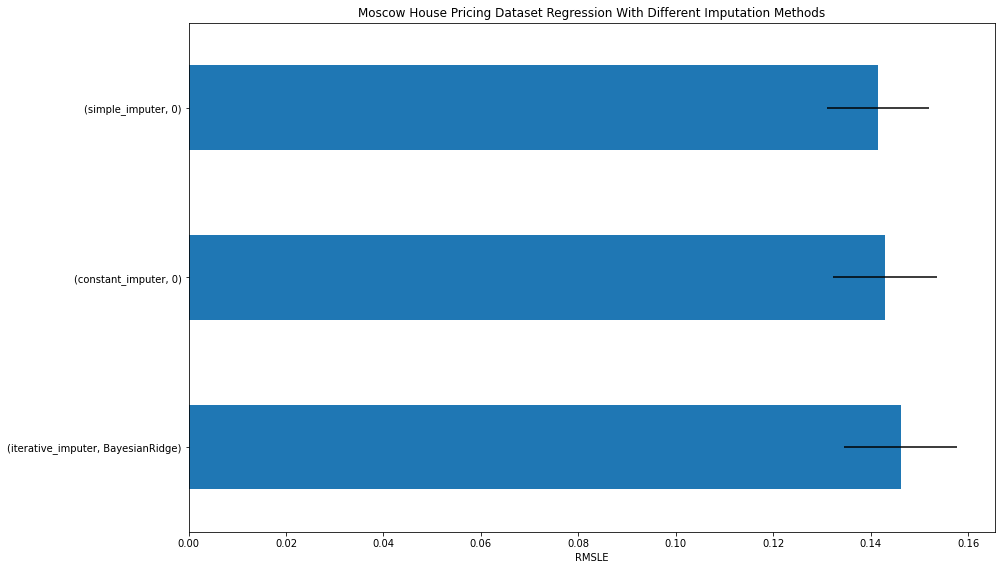

In [7]:
fig, ax = plt.subplots(figsize=(14, 8))

means, errors = final_scores.mean().sort_values(ascending=False), final_scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Moscow House Pricing Dataset Regression With Different Imputation Methods")
ax.set_xlabel("RMSLE")
ax.set_yticks(np.arange(means.shape[0]))
plt.tight_layout(pad=1)

### Plot Correlation
Plotting the correlation between features gives important information about which features are most important for predicting the target, but also insights into relationships between features.  

<AxesSubplot:>

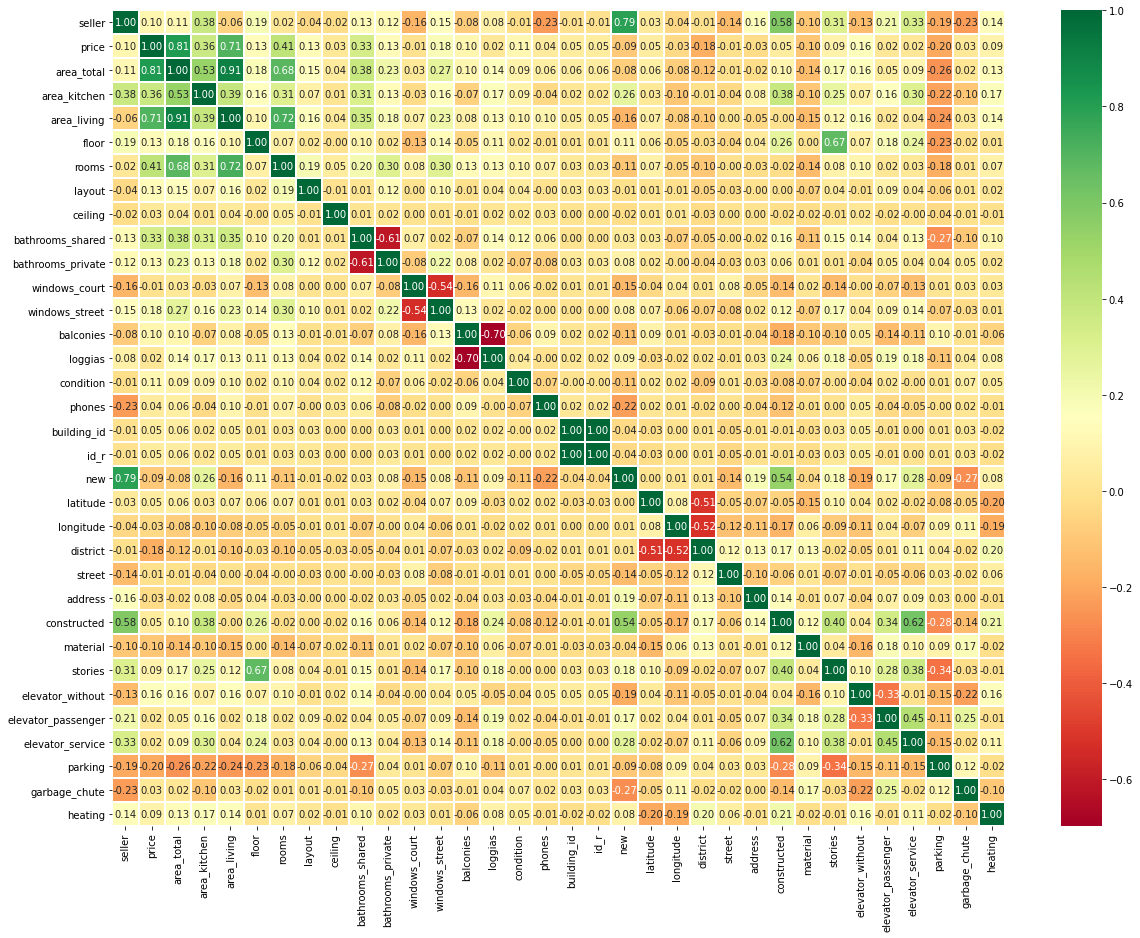

In [43]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), xticklabels=True, yticklabels=True, cmap='RdYlGn', linewidths=.2, annot=True, fmt=".2f");

From this plot we can derive insights:
- The area-related features, espeically total and living area, are highly correlated to the price. We expect them to be important.
- There is a considerable amount of features uncorrelated to the price. It might make sense to drop some of them to remove noise.
- There is strong negative correlation between balconies and loggias, as well as between windows_street and windows_court. It might make sense to add them together to gain a single feature.
- There is also negative correlation between the two types of bathrooms, but because bathrooms_shared has a considerable negative correlation to the price, we should keep them separate.

How do the correlations in the training and the test set differ?

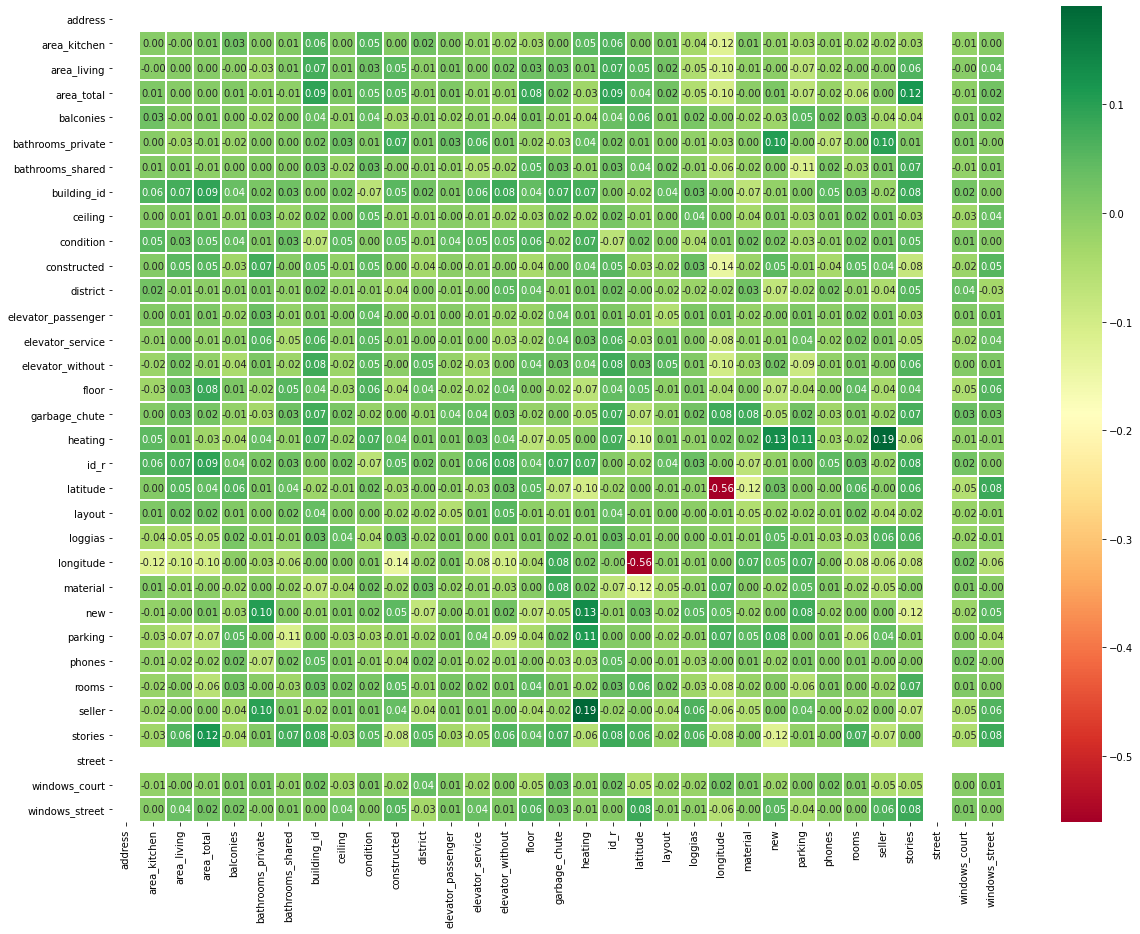

In [44]:
keys = train_df.keys().drop(["price"])
plt.figure(figsize=(20, 15))
sns.heatmap(train_df[keys].corr()-test_df[keys].corr(), xticklabels=True, yticklabels=True, cmap='RdYlGn', linewidths=.2, annot=True, fmt=".2f");

The correlations are largely similar, only a few comparatively larger differences appear between some features less correlated to the price, so this might be caused by noise. What strikes the eye is a very large difference in the coordinate features. This speaks for different locations of training and test set buildings.

### Feature Importance

To confirm the insights that the correlation plot gave us, we train a gradient boosting regressor on the full dataset. This allows us to look into the feature importances and make more educated decisions about which features to keep and which to drop. The below plot shows us how many times every feature has been split on.

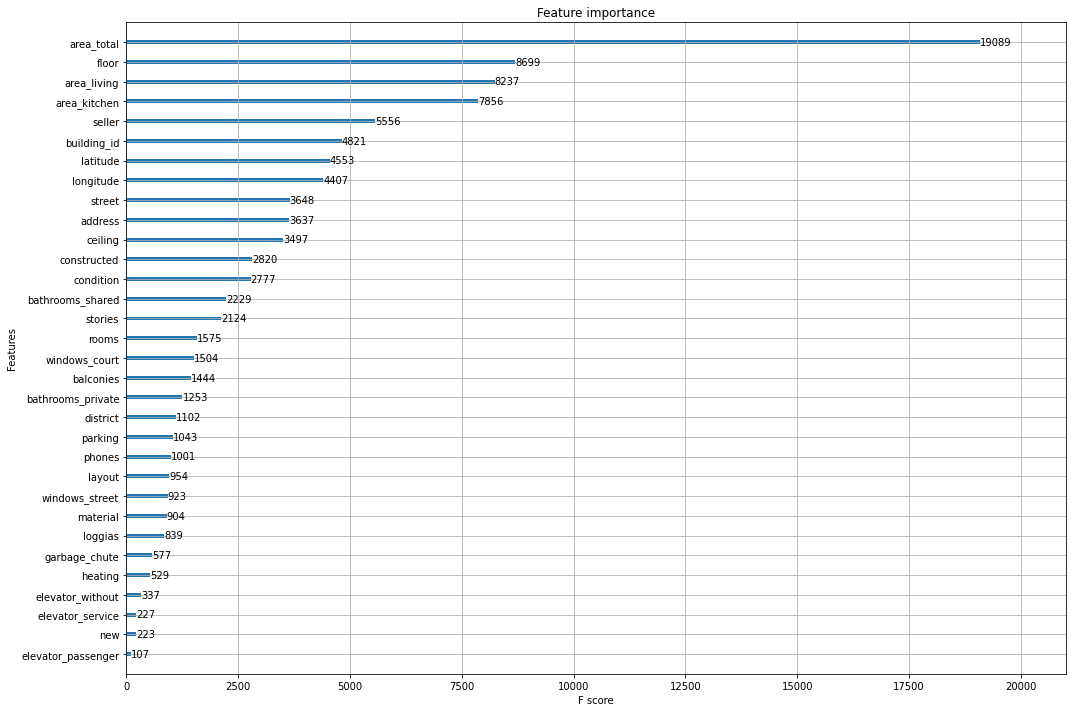

In [36]:
model_xgb = XGBRegressor(n_estimators=1200, max_depth=7, booster='gbtree')
model_xgb.fit(X, y)

fig, ax = plt.subplots(1, 1, figsize=(15,10))
plot_importance(model_xgb, ax=ax)
plt.tight_layout()

As expected, the area-related features which are most correlated to the ground truth are also the most important ones to the model. The floor exceeds our expectations in feature importance, as it was not as highly correlated to the price as the living area. We assume that the floor is a good indicator for high prices, and thus important, as apartments very high up in tall buildings are usually very costly. The least correlated ones are not of much importance.

### Exploration of Single Features and Data Cleaning

#### Coordinates
We noticed that in the test set there are coordinates far outside the Moscow city center. These are not present in the training set.

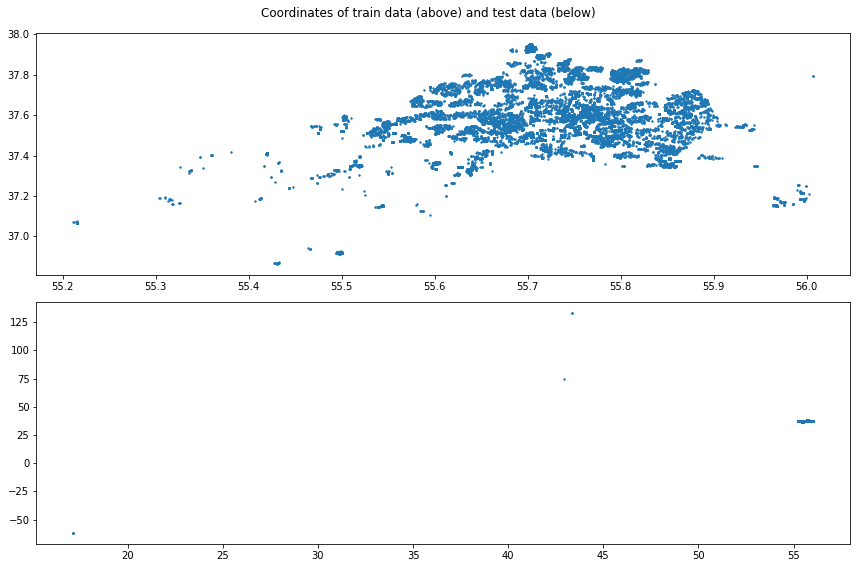

In [35]:
fig, axs = plt.subplots(2, figsize=(12, 8))
fig.suptitle("Coordinates of train data (above) and test data (below)")
axs[0].scatter(train_df.latitude, train_df.longitude, s=2)
axs[1].scatter(test_df.latitude, test_df.longitude, s=2)
plt.tight_layout()

So, with the help of the Google Maps, we corrected these coordinates.

In [9]:
# Merge features
all_data["street_and_address"] = all_data.street + " " + all_data.address

# Imputing coordinates outside of moscow and NaNs
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 37.4821752
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица 1-я Линия 57"] = 55.6324711
all_data.longitude[all_data.street_and_address == "улица 1-я Линия 57"] = 37.4536057
all_data.latitude[all_data.street_and_address == "улица Центральная 75"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 75"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица Центральная 48"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 48"] = 37.4821752

# NaNs
all_data.latitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 55.5676692
all_data.longitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 37.4816608


Furthermore, we have noticed by plotting the correlation that the coordinates in training and test set are correlated very differently. Let's check, where the buildings are located: 

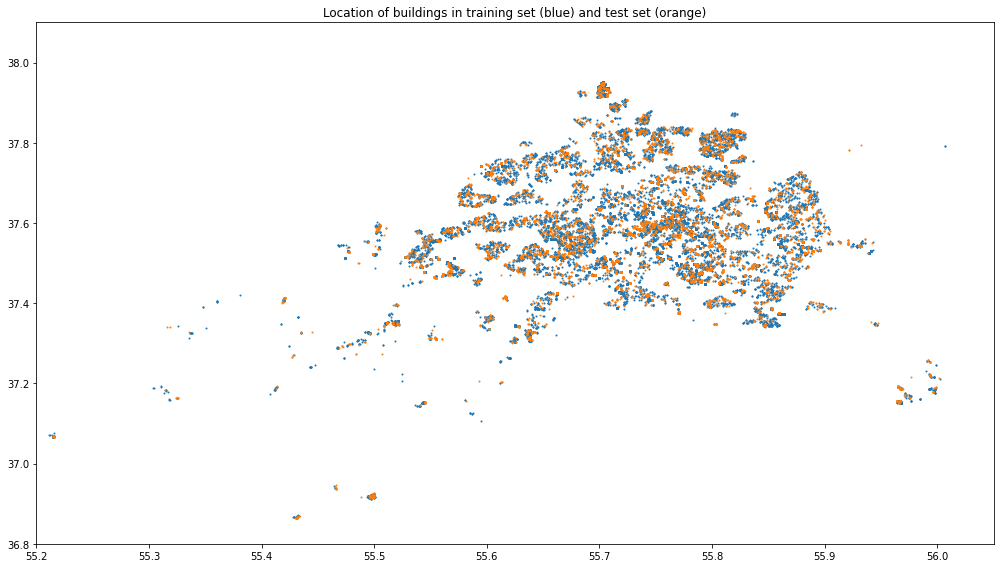

In [34]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(train_df.latitude, train_df.longitude, s=1)
plt.scatter(test_df.latitude, test_df.longitude, s=1)
plt.axis([55.2, 56.05, 36.8, 38.1])
plt.title("Location of buildings in training set (blue) and test set (orange)")
plt.tight_layout()

It appears as though the apartments are generally not in the same place. This fact is confirmed by checking if there are any overlapping building IDs, which is not the case:

In [58]:
print("Amount of shared building IDs between training and test set: ", len(set(train_df.building_id).intersection(set(test_df.building_id))))

Amount of shared building IDs between training and test set:  0


Therefore, we tried to perform the splitting within cross-validation not only according to the price but also according to building ID, i.e. we used a StratifiedGroupKFold for local verification of our model before uploading to Kaggle. We hoped that in this way the local RMSLE would adjust to the leaderboard RMSLE. However, the local score was still quite different from the leaderboard score and on top didn't represent the improvements well. This is why we decided to stay with a simple stratified split according to the price.

#### Ceiling

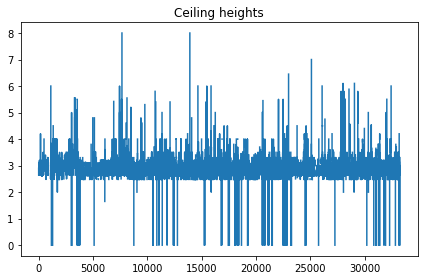

In [33]:
plt.plot(all_data.ceiling)
plt.title("Ceiling heights")
plt.tight_layout()

In [17]:
print("Amount of ceilings higher than 200m: ", len(all_data.ceiling[all_data.ceiling > 200]))
print("Amount of ceilings between 25m and 200m: ", len(all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)]))

# Rescaling out of scale ceilings
all_data.ceiling[all_data.ceiling > 200] = all_data.ceiling / 100
all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)] = all_data.ceiling / 10

Amount of ceilings higher than 200m:  31
Amount of ceilings between 25m and 200m:  8


As the plot above shows, there are several entries for ceilings which exceed hundeds of meters. We suspect that they arise from using different units for measurement, i.e. some sellers might provide this information in meters and others in centimeters or decimeters.
The ceilings are out of scale either by a factor of 100 or 10, so we tried to rescale them to have a reasonable value. However, this did not yield any improvement in RMSLE which is why we omitted this in the final solution.

#### Area
There are several entries in train and test set where the kitchen or living area exceed the total area of the apartment, as well as apartments with extraordinatily large or small total areas. To get a feel for this data, we plot it and check how many rows this applies to.

Amount of flats with total area > 1000 :  5
Amount of flats with total area < 10 :  2
Amount of flats with living area > total :  185
Amount of flats with kitchen area > total :  1
Amount of flats with living + kitchen > total :  268


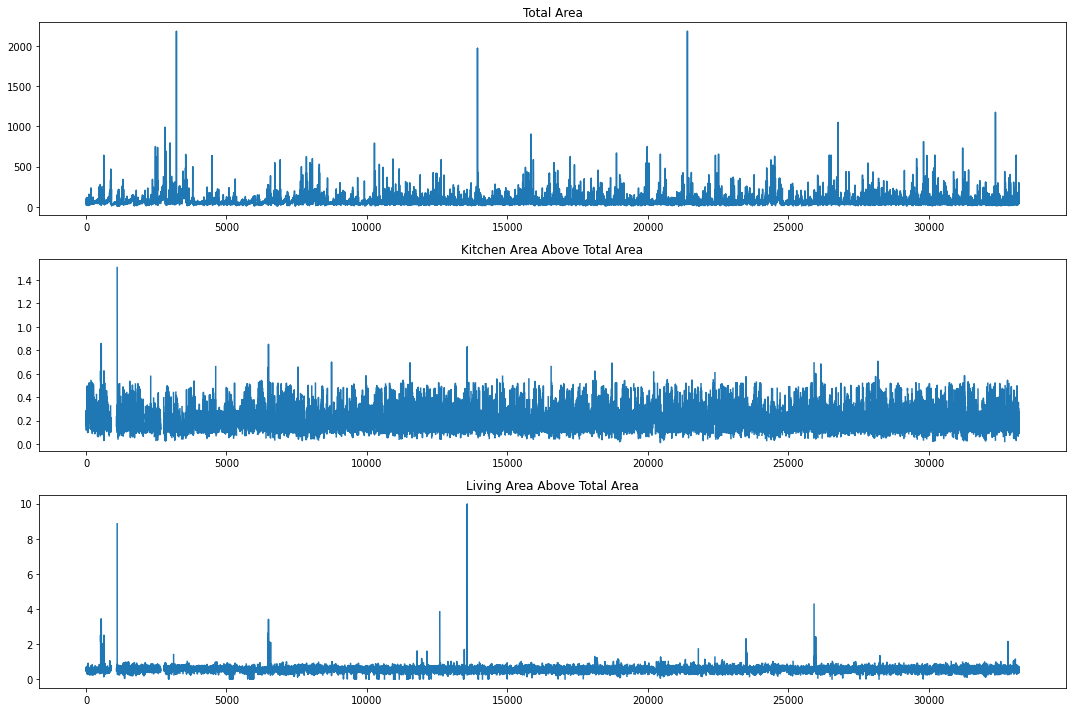

In [25]:
fig1, axs = plt.subplots(3, figsize=(15, 10))
axs[0].plot(all_data.area_total)
axs[0].set_title("Total Area")
axs[1].plot(all_data.area_kitchen/all_data.area_total)
axs[1].set_title("Kitchen Area Above Total Area")
axs[2].plot(all_data.area_living/all_data.area_total)
axs[2].set_title("Living Area Above Total Area")
plt.tight_layout()

print("Amount of flats with total area > 1000 : ", len(all_data.area_total[all_data.area_total > 1000]))
print("Amount of flats with total area < 10 : ", len(all_data.area_total[all_data.area_total < 10]))

print("Amount of flats with living area > total : ", len(all_data[all_data.area_living > all_data.area_total]))

print("Amount of flats with kitchen area > total : ", len(all_data[all_data.area_kitchen > all_data.area_total]))

print("Amount of flats with living + kitchen > total : ", len(all_data[all_data.area_living + all_data.area_kitchen > all_data.area_total]))

We believed that the entries where the living and/or kitchen areas are larger than total area were just incorrectly specified in the advert and tried to clean those by setting the kitchen area to 1/3 of the total area and the living area to 3/5 of the total area. According to the the paper mentioned in the beginning, these are the standard ratios of living and kitchen space compared to the total area of the apartment. 

In [ ]:
wrong_kitch_sq_index = all_data['area_kitchen'] > all_data['area_total']
all_data.loc[wrong_kitch_sq_index, 'area_kitchen'] = all_data.loc[wrong_kitch_sq_index, 'area_total'] * 1 / 3

wrong_life_sq_index = all_data['area_living'] > all_data['area_total']
all_data.loc[wrong_life_sq_index, 'area_living'] = all_data.loc[wrong_life_sq_index, 'area_total'] * 3 / 5

However, in our final solution this cleaning did not show to be effective. Further investigation showed that the apartments where the living and/or kitchen area is larger than the total area, 
sometimes share exactly the same kitchen and living area value and also have shared bathrooms. This is why we suspect that the kitchen space and parts of the living space may refer to common areas. We discarded this correction, as those entries may provide valuable information to the model by identifying apartments with common kitchens and living areas. This was confirmed by a submission, as the score with "corrected" sizes was worse than the one with simply keeping it this way.

In [56]:
print(all_data[["area_total", "area_kitchen", "area_living", "bathrooms_shared", "bathrooms_private"]][all_data.area_living > all_data.area_total].head())
print("Amount of flats with living > total and shared bathrooms:", len(all_data[(all_data["area_living"] > all_data["area_total"]) & (all_data["bathrooms_shared"] > 1)]))

     area_total  area_kitchen  area_living  bathrooms_shared  \
id                                                             
514        37.0          20.0         80.0               2.0   
515        32.0          20.0         80.0               2.0   
517        77.2          20.0         80.0               2.0   
523        77.0          20.0         80.0               2.0   
536        23.3          20.0         80.0               2.0   

     bathrooms_private  
id                      
514                0.0  
515                0.0  
517                0.0  
523                0.0  
536                0.0  
Amount of flats with living > total and shared bathrooms: 156


#### Rooms
We checked if there are apartments with zero rooms or bathrooms:

Amount of apartment with 0 rooms:  0
Amount of apartment with 0 bathrooms:  0


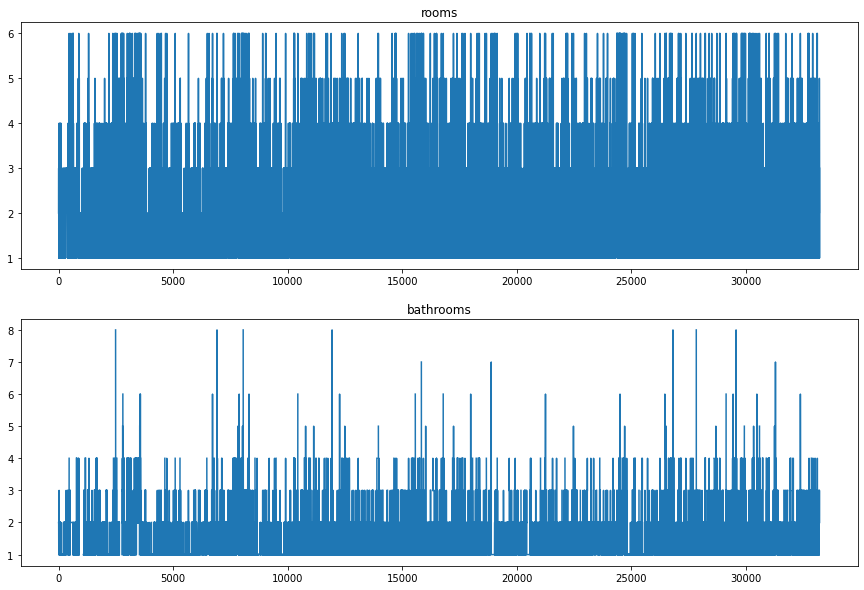

In [27]:
fig1, axs = plt.subplots(2, figsize=(15,10))
axs[0].plot(all_data.rooms)
axs[0].set_title("rooms")
axs[1].plot(all_data.bathrooms_private + all_data.bathrooms_shared)
axs[1].set_title("bathrooms")

print("Amount of apartment with 0 rooms: ", len(all_data.rooms[all_data.rooms==0]))
print("Amount of apartment with 0 bathrooms: ", len(all_data[all_data.bathrooms_shared+all_data.bathrooms_private==0]))

#### Floor

We also investigated if the specified floor level of any apartment is flawed. 
We found that some apartments are supposed to lie on a higher floor than the maximum floor of the building. As this cannot be the case, we tried to correct set the floor value of those to the stories value of the building. In the final solution this correction was not applied as it performed worse with it.

In [57]:
print("Amount of apartment with 0 floors: ", len(all_data[all_data.stories==0]))
print("Amount of apartment with floor bigger than stories: ", len(all_data[all_data.floor>all_data.stories]))

wrong_floor = all_data['floor'] > all_data['stories']
all_data.loc[wrong_floor, 'floor'] = all_data.loc[wrong_floor, 'stories']

Amount of apartment with 0 floors:  0
Amount of apartment with floor bigger than stories:  414


## Feature Engineering


### Features We Kept in the Final Model

In addition to data cleaning und discarding features of low importance, we created new features of which some improved our model. By considering the question what makes an apartment more or less expensive, we came to the conclusion that the location plays the most important role.

#### Distance to City Center
Therefore, we first added a feature which describes the distance of the apartment to the city center. In this way we extract more useful information from the given coordinates.
First, we define a distance metric, the haversine distance. It calculates the distance between two coordinates while also considering the earth's curvature. The default arguments for lat2 and lng2 are the latitude and longitude of Moscow's city center defined by the red square.

In [17]:
def haversine_array(lat1, lng1, lat2 = 55.75, lng2 = 37.6):
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        AVG_EARTH_RADIUS = 6371  # in km
        lat = lat2 - lat1
        lng = lng2 - lng1
        d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
        h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
        return h

In [18]:
all_data['center_distance'] = haversine_array(all_data['latitude'], all_data['longitude'])

In [60]:
plt.scatter(all_data.center_distance, all_data.price, s=2)
plt.title("Price in relation to distance to the city center");

AttributeError: 'DataFrame' object has no attribute 'center_distance'

As we can see, generally, the closer an apartment is to the city center, the more expensive it gets.

#### Distance to Closest Metro Station
A second important indicator for the house price may be the distance to the nearest metro station as many people which don't have cars rely on it to reach other places, especially the city center. We got the locations of all metro stations within Moscow from Wikipedia (https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations) and created a csv file. Using this, we added an additional feature to every sample, indicating the distance to the closest metro station from the apartment.

In [34]:
bulding_locs = np.asarray(list(zip(all_data['latitude'], all_data['longitude'])))
metro_locs = np.asarray(list(zip(metro_stations['latitude'], metro_stations['longitude'])))
closest_metro_dist = np.min(haversine_distances(bulding_locs, metro_locs), axis=1)
all_data['closest_metro'] = closest_metro_dist

#### Mapping each Apartment to its Subarea

The last feature we added based on the coordinates of the building was the district. We assigned every apartment to its district (or raion) using geographical data which was provided in an old kaggle competition (https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/32201). For this task we used geopandas.

In addition, we added a second similar feature which mapped each apartment to its subarea based on the euclidian distance to the center of the nearest subarea. This improves the price prediction additionally and we believe the reason could be that apartments which are located close to its subarea border sometimes share more characteristics with a neighboring subarea.

Lastly, we applied PCA on this different but correlated mappings to build a new subarea-related feature.

In [35]:
# Mapping each building to its sub_area with geopandas and the shapefile
geo_df = gp.GeoDataFrame(all_data, geometry=gp.points_from_xy(all_data.longitude, all_data.latitude))
geo_df.crs = "EPSG:4326"
all_data = gp.sjoin(sub_areas_df, geo_df, how='right', predicate='contains')
all_data = all_data.drop(["DISTRICT", "geometry", "OKATO", "OKTMO", "OKATO_AO", "index_left"], axis=1)
all_data["sub_area"] = LabelEncoder().fit_transform(all_data['sub_area'])

# Add nearest sub_area to each building based on distance to the subarea center
sub_area_locs = np.asarray(list(zip(subareas['longitude'], subareas['latitude'])))
closest_sub_idx = np.argmin(haversine_distances(bulding_locs, sub_area_locs), axis=1)
all_data["sub_area_"] = subareas['sub_area'].iloc[closest_sub_idx].values
all_data["sub_area_"] = LabelEncoder().fit_transform(all_data['sub_area_'])

# Transform both to a new feature using PCA
pca = PCA(n_components=1)
all_data["sub_area_pca"] = pca.fit_transform(all_data[["sub_area", "sub_area_"]]).squeeze()
all_data = all_data.drop(["sub_area", "sub_area_"], axis=1)

NameError: name 'gp' is not defined

#### Average Squaremeter Price in the Neighborhood

Using a BallTree nearest neighbour algorithm, we also calculate the average square meter price of 300 apartments each one and add this as a feature.

In [39]:
# Add average price in the neighborhood
tree = BallTree(all_data[["latitude", "longitude"]])
dist, ind = tree.query(all_data[["latitude", "longitude"]], k=300)

# Take log of area
all_data['area_total'] = np.log(all_data['area_total'])
mean_sqm_price = []
mean_subarea_price = []

for rows in ind:
    mean_sqm_price.append(np.nanmean(all_data['price'].iloc[rows] / all_data['area_total'].iloc[rows]))
    mean_subarea_price.append(np.nanmean(all_data['price'].iloc[rows]))

all_data["mean_sqm_price"] = mean_sqm_price
# all_data["mean_subarea_price"] = mean_subarea_price

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Finally, we plot the feature importance of the newly developed features together with the old ones. As expected, they show a high impact during construction of the decision trees.

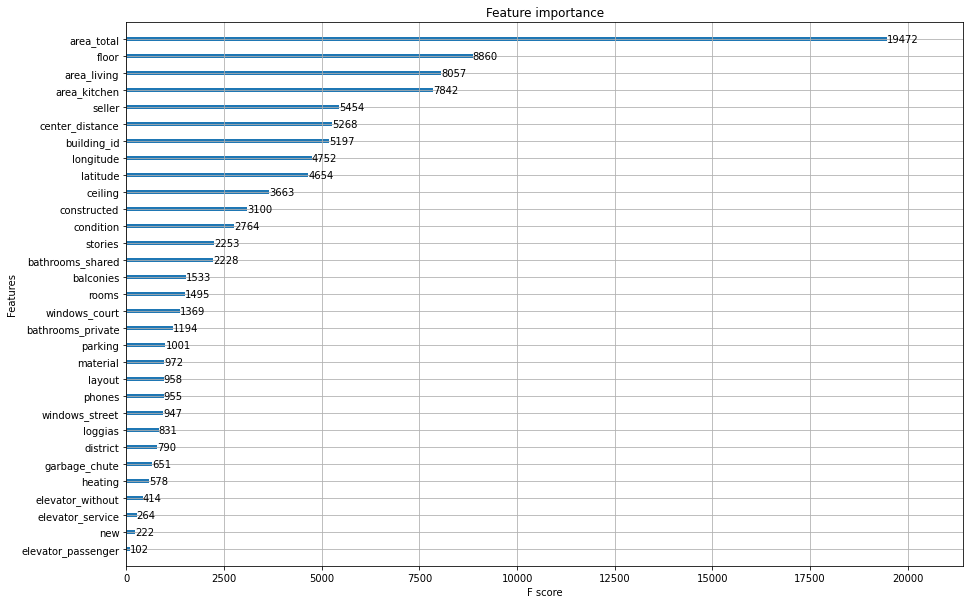

In [23]:
X = all_data[0:23285].drop(["street", "address", "price"], axis = 1)
model_xgb = XGBRegressor(n_estimators=1200, max_depth=7, booster='gbtree')
model_xgb.fit(X, y)

fig, ax = plt.subplots(1,1,figsize=(15,10))
plot_importance(model_xgb, ax=ax); #, max_num_features=25);

### Features we tried but discarded in the Final Model

#### Average Price per District

In [41]:
mean_price = train_df.groupby('district').mean().reset_index()[['district', 'price']]
train_df = train_df.merge(mean_price, how='left', on='district', suffixes=('', '_avg'))
test_df = test_df.merge(mean_price, how='left', on='district').rename(columns={'price' : 'price_avg'}).set_index(test_df.index)

#### Floor distance
From the paper we read, we found out that the number of the floor could be important, in particular it is better to be in the higher floors. That's why we added two features:
- floor_from_top: how many floors are in the middle between the apartment and the ast floor
- floor_over_stories: the percentage of the height of the floor over the total height 

In [37]:
all_data['floor_from_top'] = all_data['stories'] - all_data['floor']
all_data['floor_over_stories'] = all_data['floor'] / all_data['stories']

#### Construction year
According to Ruslan Khalitov, the data set was created in 2018. We found that some buildings have a construction date located in the future. This applies to about one third of all data.

In [59]:
print("Oldest building was built:", int(min(all_data.constructed)))
print("Newest building will be built:", int(max(all_data.constructed)))
print("Amount of buildings unfinished at data set creation: ", len(all_data[all_data.constructed > 2018]))

Oldest building was built: 1855
Newest building will be built: 2023
Amount of buildings unfinished at data set creation:  11091


We tried to introduce a new feature indicating whether the building is already constructed or will be constructed in the future. So we added the following features:
- age_of_house_before_sale: How many ages separate the selling and the construction if the house is not built yet
- sale_before_build: Boolean that checks if the house is not built yet

In [36]:
all_data['age_of_house_before_sale'] = np.where((2018 - all_data['constructed'] > 0), 2018 - all_data['constructed'], 0)
all_data['sale_before_build'] = ((2018 - all_data['constructed']) < 0).astype(int)

#### Area percentage
The percentage of how much of the total area is dedicated to the kitchen or to the living areas may be important. So we added to features to indicate the percentage of kitchen area and living area over total area.

In [38]:
all_data['area_kitchen_percentage']= all_data['area_kitchen'] / all_data['area_total']
all_data['area_living_percentage']= all_data['area_living'] / all_data['area_total']